# Setup

## Imports

In [1]:
# If colab then setup else pass to rest of the code
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    %cd /content/drive/MyDrive/Coding/spread-res/runscr/
except ImportError: pass

# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
# from classes.models import TestBert

# Import the utilities and the dataloader
from utils import parseutil, parsebert, selfutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(parseutil)
importlib.reload(parsebert)
importlib.reload(selfutil)

# Import the model and funcs required from utils
from utils.selfutil import get_fileList
from utils.parsebert import process_spreadsheet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Coding/spread-res/runscr


## Variables

In [2]:
# Load the tokenizer
from transformers import AutoTokenizer

# Define the params to pass
model_base = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_base)
max_rows = 100
max_cols = 100
pad_length = 32

# Define the directories and files
train_dir = "../data/1k_train/"
val_dir = "../data/1k_val/"
test_dir = "../data/1k_test/"

# Retrieve all file paths
train_files, _ = get_fileList(train_dir)
val_files, _ = get_fileList(val_dir)
test_files, _ = get_fileList(test_dir)

# Dataloader

In [3]:
# Import and reload the processing func
import importlib

from utils import parsebert

importlib.reload(parsebert)
import os
from typing import Any, List, Optional, Tuple

import torch
import torch.nn.functional as F
from joblib import Parallel, delayed
from tqdm import tqdm

from utils.parsebert import process_spreadsheet


class DSBert(torch.utils.data.Dataset):
    """BERT-based spreadsheet dataset with HuggingFace tokenizer.

    Handles parallel processing of files and tokenization using a BERT tokenizer.

    Attributes:
        max_rows (int): Maximum number of rows to process in each spreadsheet.
        max_cols (int): Maximum number of columns to process in each spreadsheet.
        pad_length (int): Length to pad tokenized inputs.
        tokenizer: BERT tokenizer instance.
        x_tok (List): List of tokenized inputs (input_ids).
        x_masks (List): List of attention masks.
        y_tok (List): List of metadata tensors.
        file_paths (List[str]): List of processed file paths.
        failed_files (List[str]): List of file paths that failed processing.
    """

    def __init__(
        self,
        file_paths,
        tokenizer,
        max_rows=100,
        max_cols=100,
        pad_length=32,
        threads=4,
    ):
        """Initialize loader with BERT tokenizer and processing parameters.

        Args:
            file_paths (List[str]): List of file paths to process.
            tokenizer: BERT tokenizer instance.
            max_rows (int): Maximum number of rows to process in each spreadsheet.
            max_cols (int): Maximum number of columns to process in each spreadsheet.
            pad_length (int): Length to pad tokenized inputs.
            threads (int): Number of threads for parallel processing.
        """
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        self.tokenizer = tokenizer
        self.max_rows = max_rows
        self.max_cols = max_cols
        self.pad_length = pad_length

        # Original lists for storing processed tensors
        self.x_tok = []
        self.x_masks = []
        self.x_metadata = []
        self.y_tok = []
        self.file_paths = []
        self.failed_files = []

        # Process files in parallel
        results = Parallel(n_jobs=max(1, threads), timeout=99999)(
            delayed(self.featurize)(f)
            for f in tqdm(file_paths, desc="Processing files")
        )

        # Collect results
        for x_tok, x_masks, y_tok, path in results:
            if self.is_valid(x_tok, x_masks, y_tok):
                self.x_tok.append(x_tok)
                self.x_masks.append(x_masks)
                self.y_tok.append(y_tok)
                self.file_paths.append(path)
            else:
                self.failed_files.append(path)

        print(
            f"\n{len(self.file_paths) + len(self.failed_files)}(P) = {len(self.file_paths)}(G) + {len(self.failed_files)}(E)"
        )

        # Call the function to one-hot encode the metadata
        self.onehot_metadata()

    def is_valid(self, x_tok, x_masks, y_tok):
        """Verify all tensors were generated successfully.

        Args:
            x_tok (Any): Tokenized input (input_ids).
            x_masks (Any): Attention mask.
            y_tok (Any): Metadata tensor.

        Returns:
            bool: True if all tensors were generated successfully, False otherwise.
        """
        return all(x is not None for x in (x_tok, x_masks, y_tok))

    def featurize(self, file_path):
        """Process a single spreadsheet using BERT tokenization.

        Args:
            file_path (str): Path to the file to be processed.

        Returns:
            Tuple[Optional[torch.Tensor], ...]: Processed tensors (input_ids, attention_mask, metadata) and file path.
        """
        try:
            # Use the stored tokenizer instance
            x_tok, x_masks, y_tok = process_spreadsheet(
                file_path,
                max_rows=self.max_rows,
                max_cols=self.max_cols,
                pad_length=self.pad_length,
                tokenizer=self.tokenizer,
            )
            return x_tok, x_masks, y_tok, file_path
        except Exception as e:
            # print(f"Error processing {file_path}: {e}") # Optional: for debugging
            return None, None, None, file_path

    def onehot_metadata(self):
        """Convert all relevant metadata to one-hot encodings for neural network processing.

        This function processes all metadata except position 5 (font size - too many continuous values)
        and position 6 (bold - will be handled separately as a target variable).

        Final encoding dimensions: 108 total (15+2+8+5+6+2+3+3+4+2+14+14+14+14+3+3)
        """
        # Clear any existing metadata encodings
        self.x_metadata.clear()

        # Process each spreadsheet's flattened metadata
        for sheet_idx in tqdm(
            range(len(self.y_tok)), desc="Creating comprehensive one-hot metadata"
        ):
            # Get the current spreadsheet's flattened metadata tensor [10000, 18]
            current_flat_y = self.y_tok[sheet_idx]

            # Extract each metadata key following our naming convention
            k_dtype = current_flat_y[:, :, 0]  # Type: 0-14 (15 classes)
            k_is_filled = current_flat_y[:, :, 1]  # Filled status: 0-1 (2 classes)
            k_halign = current_flat_y[:, :, 2]  # Horizontal alignment: 0-7 (8 classes)
            k_valign = current_flat_y[:, :, 3]  # Vertical alignment: 0-4 (5 classes)
            k_cell_fam = current_flat_y[:, :, 4]  # Font family: 0-5 (6 classes)
            k_italic = current_flat_y[:, :, 7]  # Italic: 0-1 (2 classes)
            k_underline = current_flat_y[:, :, 8]  # Underline: 0-2 (3 classes)
            k_script = current_flat_y[:, :, 9]  # Script: 0-2 (3 classes)
            k_case = current_flat_y[:, :, 10]  # Case: 0-3 (4 classes)
            k_is_col = current_flat_y[:, :, 11]  # Colored: 0-1 (2 classes)
            k_btop = current_flat_y[:, :, 12]  # Top border: 0-13 (14 classes)
            k_bbot = current_flat_y[:, :, 13]  # Bottom border: 0-13 (14 classes)
            k_bleft = current_flat_y[:, :, 14]  # Left border: 0-13 (14 classes)
            k_bright = current_flat_y[:, :, 15]  # Right border: 0-13 (14 classes)
            k_hmerge = current_flat_y[:, :, 16]  # Horizontal merge: 0-2 (3 classes)
            k_vmerge = current_flat_y[:, :, 17]  # Vertical merge: 0-2 (3 classes)

            # Create one-hot encodings for each metadata feature
            o_dtype = F.one_hot(k_dtype, num_classes=15).float()
            o_is_filled = F.one_hot(k_is_filled, num_classes=2).float()
            o_halign = F.one_hot(k_halign, num_classes=8).float()
            o_valign = F.one_hot(k_valign, num_classes=5).float()
            o_cell_fam = F.one_hot(k_cell_fam, num_classes=6).float()
            o_italic = F.one_hot(k_italic, num_classes=2).float()
            o_underline = F.one_hot(k_underline, num_classes=3).float()
            o_script = F.one_hot(k_script, num_classes=3).float()
            o_case = F.one_hot(k_case, num_classes=4).float()
            o_is_col = F.one_hot(k_is_col, num_classes=2).float()
            o_btop = F.one_hot(k_btop, num_classes=14).float()
            o_bbot = F.one_hot(k_bbot, num_classes=14).float()
            o_bleft = F.one_hot(k_bleft, num_classes=14).float()
            o_bright = F.one_hot(k_bright, num_classes=14).float()
            o_hmerge = F.one_hot(k_hmerge, num_classes=3).float()
            o_vmerge = F.one_hot(k_vmerge, num_classes=3).float()

            # Combine all one-hot encodings in order (108 total dimensions)
            combined_metadata = torch.cat(
                [
                    o_dtype,  # Dimensions 0-14
                    o_is_filled,  # Dimensions 15-16
                    o_halign,  # Dimensions 17-24
                    o_valign,  # Dimensions 25-29
                    o_cell_fam,  # Dimensions 30-35
                    o_italic,  # Dimensions 36-37
                    o_underline,  # Dimensions 38-40
                    o_script,  # Dimensions 41-43
                    o_case,  # Dimensions 44-47
                    o_is_col,  # Dimensions 48-49
                    o_btop,  # Dimensions 50-63
                    o_bbot,  # Dimensions 64-77
                    o_bleft,  # Dimensions 78-91
                    o_bright,  # Dimensions 92-105
                    o_hmerge,  # Dimensions 106-108
                    o_vmerge,  # Dimensions 109-111
                ],
                dim=2,
            )

            # Add the comprehensive metadata to our list
            self.x_metadata.append(combined_metadata)

    def __len__(self):
        """Return number of successfully processed files.

        Returns:
            int: Number of processed files.
        """
        return len(self.x_tok)

    def __getitem__(self, index):
        """Get processed tensors for a single spreadsheet.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            dict: Dictionary containing processed tensors and file path.
        """
        return {
            "x_tok": self.x_tok[index],
            "x_masks": self.x_masks[index],
            "x_metadata": self.x_metadata[index],
            "y_tok": self.y_tok[index],
            "file_paths": self.file_paths[index],
        }

    def get_imbalance(self):
        """Calculate the imbalance ratio of non-bold to bold cells.

        Returns:
            float: Ratio of non-bold to bold cells

        Raises:
            ValueError: If no bold cells are found in the dataset
        """
        # Get bold cell count
        bold_count = sum((tensor[:, :, 6] == 1).sum().item() for tensor in self.y_tok)

        # No bold raise error else return
        if not bold_count:
            raise ValueError(
                "No bold cells found in the dataset. Cannot calculate imbalance ratio."
            )

        return (
            sum((tensor[:, :, 6] == 0).sum().item() for tensor in self.y_tok)
            / bold_count
        )

In [4]:
# # Define dataloaders
# train_loader = DSBert(
#     file_paths=train_files,
#     tokenizer=tokenizer,
#     max_rows=max_rows,
#     max_cols=max_cols,
#     pad_length=pad_length,
#     threads=8,
# )
# val_loader = DSBert(
#     file_paths=val_files,
#     tokenizer=tokenizer,
#     max_rows=max_rows,
#     max_cols=max_cols,
#     pad_length=pad_length,
#     threads=8,
# )
# test_loader = DSBert(
#     file_paths=test_files,
#     tokenizer=tokenizer,
#     max_rows=max_rows,
#     max_cols=max_cols,
#     pad_length=pad_length,
#     threads=8,
# )

# Model Adaptation

In [5]:
# Imports
import math  # Keep math import in case needed for future pos encoding

import torch
import torch.nn as nn
from transformers import AutoModel, BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# Define the TestBert base class
class BertGrid(nn.Module):

    def __init__(self, config):
        super().__init__()

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for potential custom cell model
        self.bertModel_cell_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # If pretrained tiny then use automodel else custom for config
        if config["model_base"] == "prajjwal1/bert-tiny":
            self.bertModel_cell = AutoModel.from_pretrained(config["model_base"])
            self.final_hidden_size = self.bertModel_cell.config.hidden_size + 112
        else:
            self.bertModel_cell = BertModel(self.bertModel_cell_config)
            self.final_hidden_size = self.hidden_size + 112

        # Store the hidden size of the cell BERT model
        self.bertModel_cell_hiddenSize = self.bertModel_cell.config.hidden_size

        # Project pretrained/custom bert output to our spatial hidden size if different
        self.proj_spatial = (
            nn.Identity()
            if self.final_hidden_size == (self.hidden_size + 112)
            else nn.Linear(self.final_hidden_size, self.final_hidden_size)
        )

        # Create config to be used for potential spatial encoder
        self.bertModel_spatial_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.final_hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Custom encoder for row/col position information (uses self.bert_config)
        self.bertEncoder_spatial = BertEncoder(self.bertModel_spatial_config)

        # Precompute the exponential term from BertGrid
        self.exp_term = torch.exp(
            -torch.arange(self.final_hidden_size, device=self.device)
            * torch.log(torch.tensor(10000.0))
            / self.final_hidden_size
        )

        # Get row/col positional encodings
        self.pos_encodings = self.get_posEncoding(self.rows, self.cols)

        # Final binary classification layers (input dimension is self.hidden_size)
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.final_hidden_size, 1),
        )

    def get_posEncoding(self, num_rows, num_cols):

        # Generate positions tensor
        positions = torch.arange(num_rows * num_cols, device=self.device)

        # Precompute row and column indices just once
        i = (positions // num_cols).unsqueeze(1)
        j = (positions % num_cols).unsqueeze(1)

        # Precompute scaled indices to avoid recomputation
        i_term = i * self.exp_term
        j_term = j * self.exp_term

        # Inline evenness check and sine/cosine selections directly
        return (
            torch.where((i & 1) == 0, torch.sin(i_term), torch.cos(i_term))
            + torch.where((j & 1) == 0, torch.sin(j_term), torch.cos(j_term))
        ).unsqueeze(0)

    def forward(self, input_ids, attention_mask, metadata_tensor):
        """
        Unified forward pass for the TestBert model.
        """
        # Retrieve dimensions
        batch_size, rows, cols, seq_len = input_ids.shape
        metadata_size = metadata_tensor.shape[-1]

        # Reshape input_ids and attention_mask to match the expected dimensions
        input_ids_reshaped = input_ids.reshape(-1, seq_len)
        attention_mask_reshaped = attention_mask.reshape(-1, seq_len)
        metadata_tensor_reshaped = metadata_tensor.reshape(-1, metadata_size)

        # Pass these to get cell level output from bert model
        cell_pooler_output = self.bertModel_cell(
            input_ids=input_ids_reshaped, attention_mask=attention_mask_reshaped
        ).pooler_output

        # Concatenate the metadata tensor with the pooler output
        metdata_concat_encoding = torch.cat(
            [cell_pooler_output, metadata_tensor_reshaped], dim=1
        )

        # Reshape the metadata encoding to match the expected dimensions
        metadata_encoding_reshaped = metdata_concat_encoding.reshape(
            batch_size, rows * cols, self.bertModel_cell_hiddenSize + metadata_size
        )

        # Add positional encodings to the cell pooler output
        pos_added_encoding = metadata_encoding_reshaped + self.pos_encodings.to(
            input_ids.device
        )

        # Pass the output through the spatial projection
        projected_encoding = self.proj_spatial(pos_added_encoding)

        # Now process through the spatial encoder for enriched encodings
        spatial_encoder_output = self.bertEncoder_spatial(projected_encoding)[0]

        # Pass the output through the binary classifier
        binary_classifier_output = self.binary_classifier(spatial_encoder_output)

        # Squeeze the output to remove the last dimension
        squeezed_output = binary_classifier_output.squeeze(-1)

        # Reshape the output to match the expected dimensions
        reshaped_output = squeezed_output.reshape(batch_size, rows, cols)

        # # #### DEBUG PRINTS ####
        # print(f"\n######### PRESET PARAMS #########\n")
        # print(f"Hidden Size:\t\t{self.hidden_size}")

        # print(f"\n######### INPUTS #########\n")
        # print(f"x_tok:\t\t{input_ids.shape}")
        # print(f"x_masks:\t{attention_mask.shape}")
        # print(f"x_metadata:\t{metadata_tensor.shape}")
        # print(f"pos_encoding:\t{self.pos_encodings.shape}")

        # print(f"\n######### RESHAPED INPUTS #########\n")
        # print(f"x_tok Reshaped:\t\t{input_ids_reshaped.shape}")
        # print(f"x_masks Reshaped:\t{attention_mask_reshaped.shape}")
        # print(f"x_metadata Reshaped:\t{metadata_tensor_reshaped.shape}")

        # print(f"\n######### METADATA/POS ADDED ENCODING #########\n")
        # print(f"Cell Level Pooler Output:\t\t{cell_pooler_output.shape}")
        # print(f"Metadata Concatenated Encoding:\t\t{metdata_concat_encoding.shape}")
        # print(f"Metadata Encoding Reshaped:\t\t{metadata_encoding_reshaped.shape}")
        # print(f"Posencoding Added Encoding:\t\t{pos_added_encoding.shape}")

        # print(f"\n######### SPATIAL ENCODER OUTPUT #########\n")
        # print(f"Projected Encoding:\t\t{projected_encoding.shape}")
        # print(f"Spatial Encoder Output:\t\t{spatial_encoder_output.shape}")

        # print(f"\n######### FINAL BINARY CLASSIFIER OUTPUT #########\n")
        # print(f"Binary Classifier Output:\t\t{binary_classifier_output.shape}")
        # print(f"Binary Classifier Output Squeezed:\t{squeezed_output.shape}")
        # print(f"Binary Classifier Output Reshaped:\t{reshaped_output.shape}")

        # Return the final output after passing through the binary classifier
        return reshaped_output

In [6]:
# # Define the model
# test_model = BertGrid(test_config).to(test_config["DEVICE"])

# # Import Dataloader class
# from torch.utils.data import DataLoader

# # Define the batch size
# batch_size = 2

# # Create the test dataloader
# test_dataloader = DataLoader(train_loader, batch_size=batch_size, shuffle=False)

# # Create a single batch of data
# test_batch = next(iter(test_dataloader))

# # Extract tensors and print shapes
# x_tok = test_batch["x_tok"].to(test_config["DEVICE"])
# x_masks = test_batch["x_masks"].to(test_config["DEVICE"])
# x_metadata = test_batch["x_metadata"].to(test_config["DEVICE"])

# # Forward pass through the model
# output = test_model(x_tok, x_masks, x_metadata)

# Training

## Functions

In [7]:
# Imports
import copy
import json
import math
import os
import sys
import time

import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm


def train_model(
    model,
    train_data,
    val_data,
    DEVICE,
    batch_size=8,
    lr=1e-2,
    mu=0.25,
    max_epochs=3,
    patience=2,
    save_int=2,
    save_dir="../models/",
    save_name="model_",
    config=None,
    isPerp=False,
):
    """
    Unified training function that handles both BERT and non-BERT models.
    """

    # Record training start time
    start_time = time.time()

    # ---------- 1. SETUP ----------#

    # 1a. LOGGING MODEL PATH AND FILE
    model_path, log_file = setup_logging(save_int, save_dir, save_name, config)

    # 1b. OPTIMIZER
    opt = torch.optim.AdamW(
        model.parameters(), lr=lr, betas=(0.85, 0.999), weight_decay=0.015
    )

    # 1c. DATALOADERS
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_data, batch_size=batch_size, shuffle=False
    )

    # 1d. LOSS FUNCTION
    loss_fn = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([train_data.get_imbalance()], dtype=torch.float).to(
            DEVICE
        )
    )

    # 1e. INITIAL TRACKING VARIABLES
    epoch = 0
    best_epoch = 0
    nimp_ctr = 0
    best_avgtrloss = float("inf")
    best_avgvalloss = float("inf")
    best_perp = float("inf")
    best_valperp = float("inf")
    isTraining = True

    # ---------- 2. MODEL MAIN LOOP ----------#

    # While isTraining True and max epochs is not reached keep training model
    while isTraining and (epoch < max_epochs):

        # Print epoch number. Log if applicable
        print(f"Epoch {epoch}")
        if save_int > 0:
            with open(log_file, "a") as log:
                log.write(f"\nEpoch {epoch}\n")

        # Define initial values of current train/val loss for the epoch
        curr_trloss = 0
        curr_valloss = 0

        # ---------- 3. TRAINING LOOP ----------#

        # Shift model to training mode
        model.train()

        # Loop through all batches in train loader
        for i, batch in enumerate(tqdm(train_loader, desc="Batch Processing")):

            # Zero the model gradients and avoid 0 matrices when no grads
            model.zero_grad(set_to_none=True)

            # Forward pass to get logits
            logits = model(
                batch["x_tok"].to(DEVICE),
                batch["x_masks"].to(DEVICE),
                batch["x_metadata"].to(DEVICE),
            ).view(-1)

            # Extract labels from batch
            labels = batch["y_tok"][:, :, :, 6].to(DEVICE).view(-1).float()

            # Calculate loss using loss function
            loss = loss_fn(logits, labels)

            # Add to current training loss on CPU to reduce GPU memory usage
            curr_trloss += loss.detach().cpu().item()

            # Backpropogate the loss
            loss.backward()

            # Clip gradients using passed mu value
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=mu)

            # Step optimizer
            opt.step()

            # Delete loss parameter to free memory
            del loss

        # ---------- 4. VALIDATION LOOP ----------#

        # Switch model to evaluation mode
        model.eval()

        # Loop through all batches in validation loader
        for i, batch in enumerate(tqdm(val_loader, desc="Validation Processing")):

            # Disable gradients
            with torch.no_grad():

                # Get logits
                val_logits = model(
                    batch["x_tok"].to(DEVICE),
                    batch["x_masks"].to(DEVICE),
                    batch["x_metadata"].to(DEVICE),
                ).view(-1)

                # Get labels
                val_labels = batch["y_tok"][:, :, :, 6].to(DEVICE).view(-1).float()

                # Calculate validation loss
                val_loss = loss_fn(val_logits, val_labels)

                # Add to current validation loss on CPU to reduce GPU memory usage
                curr_valloss += val_loss.detach().cpu().item()

        # Calculate metrics and handle early stopping
        curr_avgtrloss = curr_trloss / len(train_loader)
        curr_perp = math.exp(
            curr_trloss
            / (len(train_loader) * batch_size * config["rows"] * config["cols"])
        )
        curr_avgvalloss = curr_valloss / len(val_loader)
        curr_valperp = math.exp(
            curr_valloss
            / (len(val_loader) * batch_size * config["rows"] * config["cols"])
        )

        # Print and log metrics
        if isPerp:
            print(f"Train Loss: {curr_avgtrloss:.4e}, Perplexity: {curr_perp:.4e}")
            print(f"Val Loss: {curr_avgvalloss:.4e}, Perplexity: {curr_valperp:.4e}\n")
        else:
            print(
                f"Train Loss: {curr_avgtrloss:.4e}, Val Loss: {curr_avgvalloss:.4e}\n"
            )
        if save_int > 0:
            with open(log_file, "a") as log:
                log.write(f"Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}\n")
                log.write(f"Val Loss: {curr_avgvalloss}, Perplexity: {curr_valperp}\n")

        # Early stopping logic
        if curr_valperp < best_valperp:
            best_perp = curr_perp
            best_valperp = curr_valperp
            best_avgtrloss = curr_avgtrloss
            best_avgvalloss = curr_avgvalloss
            best_epoch = epoch
            nimp_ctr = 0
        else:
            nimp_ctr += 1

        if nimp_ctr >= patience:
            # Calculate current training time
            current_train_time = time.time() - start_time
            mins, secs = divmod(current_train_time, 60)
            time_str = f"{int(mins):02d}:{int(secs):02d}"

            print(f"\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}")
            if isPerp:
                print(
                    f"Train Loss = {best_avgtrloss:.4e}, Perplexity = {best_perp:.4e}"
                )
                print(
                    f"Val Loss = {best_avgvalloss:.4e}, Perplexity = {best_valperp:.4e}"
                )
            else:
                print(
                    f"Train Loss = {best_avgtrloss:.4e}, Val Loss = {best_avgvalloss:.4e}"
                )
            print(f"Total Training Time = {time_str}")

            if save_int > 0:
                with open(log_file, "a") as log:
                    log.write(
                        f"\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}\n"
                    )
                    log.write(
                        f"Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n"
                    )
                    log.write(
                        f"Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n"
                    )
                    log.write(f"Total Training Time = {time_str}\n")
            isTraining = False

        # Save model if needed
        if save_int > 0 and (epoch + 1) % save_int == 0:
            torch.save(model.state_dict(), model_path)
            print("Model Saved")
            with open(log_file, "a") as log:
                log.write("Model Saved\n")

        epoch += 1
        print()

    # Calculate total training time
    total_train_time = time.time() - start_time
    mins, secs = divmod(total_train_time, 60)
    time_str = f"{int(mins):02d}:{int(secs):02d}"

    # Final print
    print(f"\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}")
    print(f"Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
    print(f"Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}")
    print(f"Total Training Time = {time_str}")

    # Final save and logging
    if save_int > 0:
        torch.save(model.state_dict(), model_path)
        with open(log_file, "a") as log:
            log.write(f"\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}\n")
            log.write(f"Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n")
            log.write(f"Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n")
            log.write(f"Total Training Time = {time_str}\n")

    return model


def setup_logging(save_int, save_dir, save_name, config):
    """Setup logging and model saving paths.

    Args:
        save_int: Saving interval, if 0 then no intermediate saves
        save_dir: Directory to save model and logs
        save_name: Base name for saved files
        config: Configuration dictionary for model

    Returns:
        tuple: (model_path, log_file) or (None, None) if saving disable
    """
    # Common setup
    torch.set_printoptions(profile="full")

    # Return early if saving disabled
    if save_int == 0:
        return None, None

    # Validate save directory exists
    if not os.path.exists(save_dir):
        raise ValueError(f"Directory '{save_dir}' DNE")

    # Setup paths using the save_name directly (timestamp now included in save_name)
    model_path = os.path.join(save_dir, f"{save_name}.pth")
    log_file = os.path.join(save_dir, f"{save_name}.txt")

    # Handle config logging if config provided
    if config is not None:

        # Create copy and setup removes list
        config_serializable = copy.deepcopy(config)
        removes = ["DEVICE", "train_loader", "val_loader", "test_loader"]
        removes += (
            ["tokenizer"] if config.get("approach") == "bert" else ["vocab", "wvs"]
        )

        # Remove non-serializable items
        for item in removes:
            config_serializable.pop(item, None)

        # Write config to log file
        with open(log_file, "w") as log:
            log.write("\nFinal configuration:\n")
            log.write(json.dumps(config_serializable, indent=2))
            log.write("\n\n" + "=" * 80 + "\n\n")

    # Return final modle path and log file
    return model_path, log_file

In [8]:
# Define configuration needed for the model
test_config = {
    "vocab_size": 30522,  # Default from docs
    "hidden_size": 128,
    "num_hidden_layers": 2,
    "num_attention_heads": 2,
    "intermediate_size": 512,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "max_position_embeddings": 64,
    "type_vocab_size": 2,
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-12,
    "pad_token_id": 0,
    "gradient_checkpointing": False,
    "seed": 0,
    "DEVICE": torch.device("cuda:0"),
    "rows": 100,
    "cols": 100,
    "tokens": 32,
    "model_base": "bert-base-cased",
    "batch_size": 2,
    "lr": 5e-5,
    "mu": 0.25,
    "epochs": 50,
    "patience": 1,
    "save_int": 0,
    "approach": "bert",
}

# Setup datasets
train_ds = DSBert(
    file_paths=train_files,
    tokenizer=tokenizer,
    max_rows=max_rows,
    max_cols=max_cols,
    pad_length=pad_length,
    threads=10,
)
val_ds = DSBert(
    file_paths=val_files,
    tokenizer=tokenizer,
    max_rows=max_rows,
    max_cols=max_cols,
    pad_length=pad_length,
    threads=10,
)
test_ds = DSBert(
    file_paths=test_files,
    tokenizer=tokenizer,
    max_rows=max_rows,
    max_cols=max_cols,
    pad_length=pad_length,
    threads=10,
)

# Define the tester model and move loaders to the device
test_model = BertGrid(test_config).to(test_config["DEVICE"])


Processing files: 100%|██████████| 800/800 [02:33<00:00,  5.21it/s]



800(P) = 800(G) + 0(E)


Processing files: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]



100(P) = 100(G) + 0(E)


Processing files: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]



100(P) = 100(G) + 0(E)


Creating comprehensive one-hot metadata: 100%|██████████| 100/100 [00:00<00:00, 146.04it/s]


In [9]:
# Call the train_model function
trained_model = train_model(
    model=test_model,
    train_data=train_ds,
    val_data=val_ds,
    DEVICE=test_config["DEVICE"],
    batch_size=test_config["batch_size"],
    lr=test_config["lr"],
    mu=test_config["mu"],
    max_epochs=test_config["epochs"],
    patience=test_config["patience"],
    save_int=test_config["save_int"],
    save_dir="../models/",
    save_name="test_model",
    config=test_config,
)

Epoch 0


Validation Processing: 100%|██████████| 50/50 [00:05<00:00,  9.02it/s]


Train Loss: 9.7316e-01, Val Loss: 3.2976e-01


Epoch 1


Validation Processing: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]

Train Loss: 1.3283e+00, Val Loss: 9.0063e-01


EARLY STOPPING at epoch 1, best epoch 0
Train Loss = 9.7316e-01, Val Loss = 3.2976e-01
Total Training Time = 04:30


TRAINING DONE at epoch 1, best epoch 0
Train Loss = 0.9731617102771998, Perplexity = 1.0000486592693376
Val Loss = 0.3297591584920883, Perplexity = 1.0000164880938518
Total Training Time = 04:30


# Inference


Filename: ../data/1k_train/09q2ffelstate.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(94,17): 0.003633 | (98,9): 0.003657 | (94,19): 0.003754 | (94,15): 0.003807 | (94,13): 0.003809 | (92,15): 0.003826 | (90,17): 0.003871 | (94,9): 0.003900 | (92,17): 0.003969 | (90,19): 0.003993 | (92,19): 0.004087 | (98,19): 0.004103 | (98,17): 0.004185 | (72,19): 0.004281 | (90,15): 0.004294 | (84,13): 0.004358 | (96,17): 0.004379 | (96,19): 0.004412 | (94,11): 0.004416 | (92,9): 0.004457 | (84,15): 0.004489 | (96,15): 0.004594 | (90,13): 0.004603 | (88,17): 0.004625 | (98,15): 0.004673 | (92,11): 0.004675 | (78,17): 0.004693 | (92,13): 0.004693 | (78,19): 0.004770 | (96,11): 0.004783 | (86,17): 0.004824 | (84,19): 0.004835 | (88,19): 0.004854 | (84,17): 0.004869 | (76,17): 0.004882 | (90,9): 0.004900 | (96,13): 0.004906 | (98,7): 0.004925 | (76,15): 0.004939 | (80,17): 0.004958 | (86,19): 0.004980 | (94,7): 0.005007 | (88,13): 0.005028 | (76,19): 0.005031 | (88,9): 0.005047 | (96,9): 

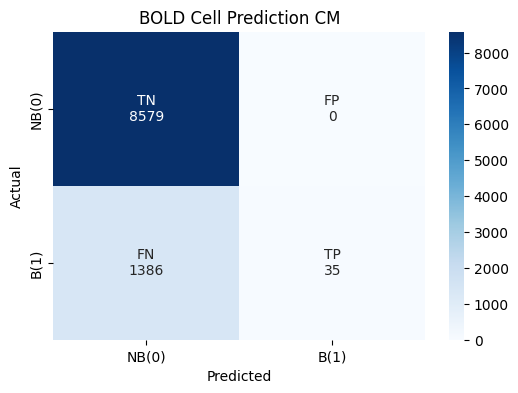


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,3,5,6,7,8,9,11,13,14,15,16,18,20
4,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,1,0,1,1,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,1,0,1,0,1,0
9,1,1,1,0,1,0,0,1,1,1,1,1,1
15,1,0,0,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,0,1,0
27,0,0,0,0,0,0,0,0,0,0,0,1,1
29,0,0,0,0,0,0,0,0,0,0,0,1,0
31,0,0,0,0,0,0,0,0,0,0,0,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,0,1
9,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1
10,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
13,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



Filename: ../data/1k_val/DE-EE0007347%20T14.4%20SR-RR-0530%20Climate%20Control%20PD%20v3.6%2006-27-2018%20%281%29.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
No bold cells in the actual data.

NB to B ratio: Predicted = 10000:0 | Actual = 10000:0
Accuracy: 100.00% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



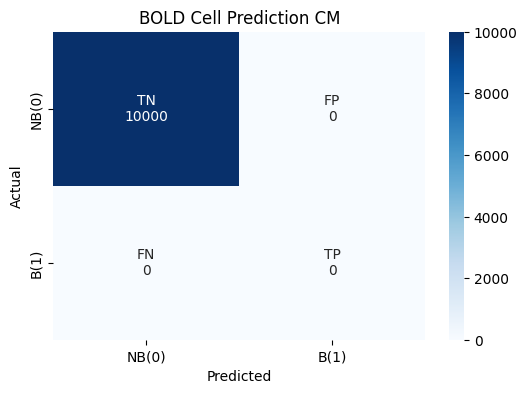


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---
No bold cells predicted.

--- Actual Grid (1 = Bold, 0 = Not Bold) ---
No bold cells in actual data.

Filename: ../data/1k_test/DeWittTheodore%20data.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(34,0): 0.677411 | (21,0): 0.883463 | (21,1): 0.921586 | (20,0): 0.929589 | (2,0): 0.961187 | (2,1): 0.982671 | (1,0): 0.990247

NB to B ratio: Predicted = 9981:19 | Actual = 9993:7
Accuracy: 99.84% | Precision: 26.32% | Recall: 71.43% | F1-Score: 0.38



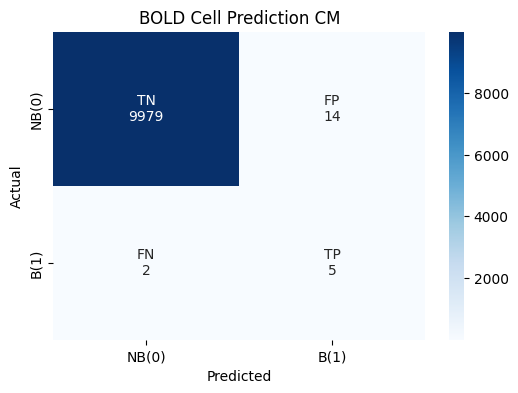


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1
1,1,0
2,1,1
3,1,0
4,1,0
5,1,1
6,1,1
8,1,0
9,1,0
10,1,0
11,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1
1,1,0
2,1,1
20,1,0
21,1,1
34,1,0


In [10]:
#Import
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import infer_one, infer_full

# Params
loc = 10
thresh = 0.9

# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_ds,
    loc=loc,
    threshold=thresh,
    device=test_config["DEVICE"],
    config=test_config,
    disp_sig=True,
)
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_ds,
    loc=loc,
    threshold=thresh,
    device=test_config["DEVICE"],
    config=test_config,
    disp_sig=True,
)
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_ds,
    loc=loc,
    threshold=thresh,
    device=test_config["DEVICE"],
    config=test_config,
    disp_sig=True,
)

Batch Inference: 100%|██████████| 400/400 [00:46<00:00,  8.60it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 7969407:30593 | Actual = 7976877:23123
Accuracy: 99.60% | Precision: 33.75% | Recall: 64.42% | F1-Score: 0.37



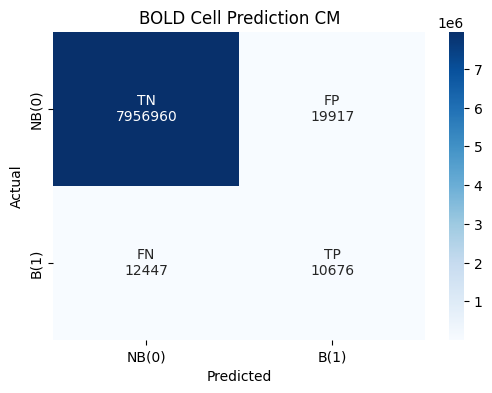

Batch Inference: 100%|██████████| 50/50 [00:05<00:00,  8.62it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 996461:3539 | Actual = 997452:2548
Accuracy: 99.64% | Precision: 29.66% | Recall: 57.20% | F1-Score: 0.31



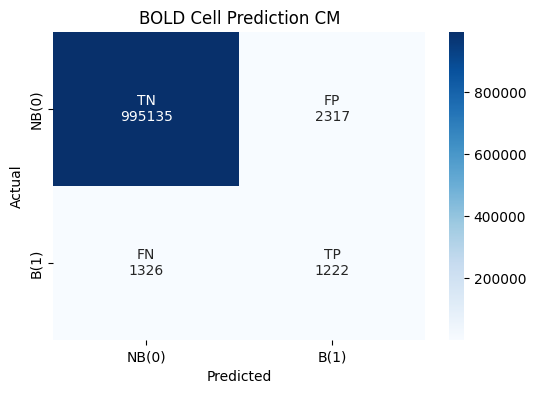

Batch Inference: 100%|██████████| 50/50 [00:05<00:00,  8.60it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 996124:3876 | Actual = 997581:2419
Accuracy: 99.64% | Precision: 33.86% | Recall: 61.23% | F1-Score: 0.37



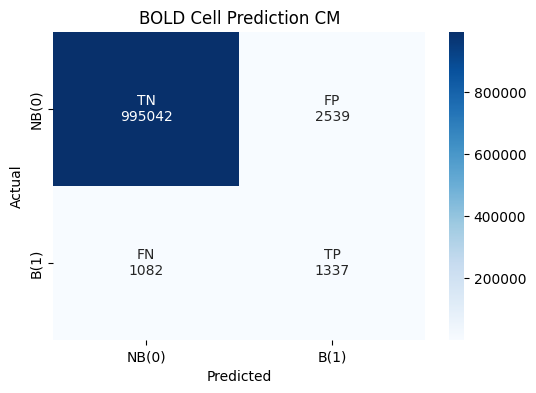

In [11]:
DEVICE = test_config['DEVICE']
batch_size = test_config['batch_size']

# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_ds,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    config=test_config,
)

# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_ds,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    config=test_config,
)

# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_ds,
    batch_size=batch_size,
    threshold=thresh,
    device=DEVICE,
    config=test_config,
)